# SniffNets

This notebook contains the implementation of the SniffNets models created for clasifying the codification of signals deteced from artificial noses

* Disclaimer: Unfortunately the Coffee dataset is not publicly available.


In [ ]:
# Run this block it you are using google colaboratory and desire to save the results in
# google drive
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
!git clone https://github.com/IsmaelCesar/SniffNets.git

Cloning into 'SniffNets'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (182/182), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 775 (delta 123), reused 115 (delta 59), pack-reused 593
Receiving objects: 100% (775/775), 178.63 MiB | 29.92 MiB/s, done.
Resolving deltas: 100% (424/424), done.
Checking out files: 100% (132/132), done.


In [ ]:
import os
import numpy as np
import time
import csv
import logging
import pickle as pkl
%tensorflow_version 1.x
import keras
from keras.layers import Conv2D
from keras.models import Sequential
from keras.layers import AveragePooling2D
from keras.layers import MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten,Dropout,Add
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.layers.merge import concatenate

import sklearn
import sklearn.neighbors.KNeighborsClassifier as KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.svm import SVC


import matplotlib.pyplot as plt

global data_folder,data_sets,ds_wine,extension
global dataset_name,sub_dataset_name,experiments_folder

data_folder = "SniffNets/data/"
global_dir = "drive/My Drive/"

experiments_folder = os.path.join(global_dir,"windowed_experiments_mean_stdd/")

if not os.path.exists(experiments_folder):
    os.mkdir(experiments_folder)
dataset_name=""
sub_dataset_name=""

### Data Loading resources

In [ ]:
extension = ".pkl"
data_sets   = {
    "fonollosa":{0: "B1-system",
                 1: "B2-system",
                 2: "B3-system",
                 3: "B4-system",
                 4: "B5-system",
                 "n_classes": 4
                 },
    "turbulent_gas_mixtures": {0: "preloaded_dataset", "n_classes": 4},
    "windtunnel": {
                0: "preloaded_dataset-L1",
                1: "preloaded_dataset-L2",
                2: "preloaded_dataset-L3",
                3: "preloaded_dataset-L4",
                4: "preloaded_dataset-L5",
                5: "preloaded_dataset-L6",
                "n_classes": 11,
                }
    # Un comment the following line if you have been authorized to use the dataset
    # ,"coffee_dataset": {0: "preloaded_dataset", "n_classes": 3}
}
ds_wine = {"QWines-CsystemTR":3,
            "QWinesEa-CsystemTR":4}

def load(ds_choice, ds_idx=0):
    """
    choices : 0 -> fonollosa, 1 -> turbulent_gas_mixtures, 2 -> windtunnel
    :param ds_choice: the index naming the dataset chosen
    :param ds_idx: the index if the folder containing the dataset has one or more datasets
    :return: the dataset read,the labels and  the number of classes
    """
    global data_folder, data_sets, extension, dataset_name, sub_dataset_name
    assert ds_choice in list(data_sets.keys())
    # ds_name =[ds_choice]
    ds_name = ds_choice
    dataset_name = ds_name+"/"

    logging.info(ds_name + " Is being loaded")

    n_classes = data_sets[ds_name]['n_classes']
    print("\n\n ds_name:"+ds_name+"\n\n")
    print("\n\n ds_idx"+str(ds_idx)+"\n\n")
    subds_name = data_sets[ds_name][ds_idx]
    sub_dataset_name = subds_name + "/"

    data ,labels = None,None
    with open(data_folder+ds_name+"/"+subds_name+extension, 'rb') as d:
        data, labels, _ = pkl.load(d)
        d.close()

    return data, labels, n_classes, dataset_name, sub_dataset_name

def load_wine(ds_choice):
    """
    choices : 0 -> QWines-CsystemTR, 1 -> QWinesEa-CsystemTR
    :param ds_choice: the index naming the dataset chosen
    :param ds_idx: the index if the folder containing the dataset has one or more datasets
    :return: the dataset read,the labels and  the number of classes
    """
    global data_folder, ds_wine, extension

    assert ds_choice in list(ds_wine.keys())
    ds_name = ds_choice
    dataset_name = ds_name+'/'

    logging.info(ds_name + " Is being loaded")

    n_classes = ds_wine[ds_name]

    data,labels = None,None
    with open(data_folder+"wines/"+ds_name+extension,"rb") as d:
        data, labels, _, _ = pkl.load(d)
        d.close()

    return data, labels, n_classes, dataset_name, sub_dataset_name



In [ ]:
def data_set_reshaped(data_set):
    newData = []
    for d in data_set:
        newData.append(d.reshape(d.shape[0], d.shape[1],1).tolist())
    return np.array(newData)

def load_and_split(ds_choice,ds_idx=0,read_wine_datasets=False):
    # Loading dataset
    global input_shape,n_classes,dataset_name,sub_dataset_name
    data = None
    labels = None
    if not read_wine_datasets:
        data, labels, n_classes,dataset_name,sub_dataset_name = load(ds_choice,ds_idx)
    else:
        data, labels, n_classes, dataset_name, sub_dataset_name = load_wine(ds_choice)

    train_data, test_data,train_labels, test_labels = train_test_split(data,labels,test_size=.2)
    train_data = data_set_reshaped(train_data)
    test_data  = data_set_reshaped(test_data)

    input_shape = train_data[0].shape

    train_data,train_labels =   sklearn.utils.shuffle(train_data,train_labels)
    test_data, test_labels = sklearn.utils.shuffle(test_data, test_labels)


    return train_data,train_labels,test_data,test_labels

In [ ]:
def standardize_data(train_data, test_data, input_shape):

    flat_train_data = train_data.reshape(train_data.shape[0], input_shape[0] * input_shape[1])
    flat_test_data = test_data.reshape(test_data.shape[0], input_shape[0] * input_shape[1])

    scaler = sklearn.preprocessing.StandardScaler().fit(flat_train_data)
    flat_train_data = scaler.transform(flat_train_data)

    scaler = sklearn.preprocessing.StandardScaler().fit(flat_test_data)
    flat_test_data = scaler.transform(flat_test_data)

    new_train = flat_train_data.reshape(train_data.shape[0], input_shape[0], input_shape[1], 1)
    new_test = flat_test_data.reshape(test_data.shape[0], input_shape[0], input_shape[1], 1)
    return new_train, new_test

In [ ]:
def split_datasamples_by_sensors(data):
    shape = data.shape
    new_split = []
    # Iterate over data columns
    for i in range(shape[2]):
        new_split.append(data[:, :, i])
        new_split[i] = new_split[i].reshape(new_split[i].shape[0], new_split[i].shape[1])
    return new_split

### Models Implementation

In [ ]:
def sniffnet(input_shape,n_classes):
    kernel = (20, input_shape[1] // 2 - 1)
    multiplier = 10
    out_channels = 5 * multiplier
    # convolutional components
    model = Sequential()
    model.add(Conv2D(out_channels, kernel, input_shape=input_shape, use_bias=True,
                    activation='relu', name='first_conv'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    kernel = ((input_shape[0]-kernel[0]+1)//2, kernel[1])
    model.add(Conv2D(out_channels, kernel, use_bias=True,
                    activation='relu', name='second_conv'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    model.add(AveragePooling2D())
    model.add(Flatten())
    model.add(Dense(out_channels, use_bias=True, activation='relu', name="camada_fc1"))
    model.add(BatchNormalization())
    model.add(Dense(n_classes, use_bias=True, activation='softmax', name="classificaiton"))

    return model
        
  

In [ ]:
def sniffresnet(input_shape, n_classes):
    multiplier = 4
    kernel = (8, input_shape[1] // 2 - 1)
    out_channels = 5 * multiplier
    # First Part of the convolution
    X_input = Input(input_shape)
    X_skip = Conv2D(out_channels, kernel, activation='relu', name='first_conv1')(X_input)
    X = Conv2D(out_channels, kernel, padding='same', activation='relu', name='first_conv2')(X_skip)
    X = BatchNormalization()(X)
    X = Add()([X, X_skip])
    X = MaxPooling2D((2, 1), padding='same', name="max_pool1")(X)

    # Second Part of the convolution
    out_channels = out_channels * multiplier
    X_skip = Conv2D(out_channels, kernel, activation='relu', name='second_conv1')(X)
    X = Conv2D(out_channels, kernel, padding='same', use_bias=True, activation='relu', name='second_conv2')(X_skip)
    X = BatchNormalization()(X)
    X = Add()([X, X_skip])
    X = MaxPooling2D((2, 1), name="max_pool2")(X)

    # Fully Connected Part
    X = Flatten()(X)
    X = Dense(100, use_bias=True, activation="relu", name="fc1")(X)
    X = Dropout(.25)(X)
    X = Dense(n_classes, use_bias=True, activation="softmax", name="class")(X)

    model = Model(inputs=X_input, outputs=X, name="SniffResnet")

    return model

In [ ]:
def sniffmultinose(input_shape,n_classes):
    inputs_list = []
    multinose_out = []
    for i in range(input_shape[1]):
        X_input = Input((input_shape[0],), name=("input_nose_" + str(i)))
        inputs_list.append(X_input)
        X = Dense(input_shape[0], input_shape=(input_shape[0],),
                  use_bias=True, activation='relu', name=("fc1_nose_" + str(i)))(X_input)
        X = Dense(input_shape[0] // 4, use_bias=True, activation='tanh', name=("fc2_nose_" + str(i)))(X)
        X = Dense(input_shape[0] // 8, use_bias=True, activation='tanh', name=("fc3_nose_" + str(i)))(X)
        multinose_out.append(X)

    concat = concatenate(multinose_out)

    X = Dense(100, activation='tanh', use_bias=True)(concat)
    X = Dense(100, activation='relu', use_bias=True)(X)
    X_out = Dense(n_classes, activation='softmax', name="class")(X)

    model = Model(inputs=inputs_list, outputs=X_out, name="SniffNetMultiNose")
    return model

In [ ]:
def get_knn_classifier(n_neighbors): 
    return KNN(n_neighbors=3)

def get_svm(m_gamma=8.3):
    return SVC(gamma=gamma, C=10, kernel='rbf')

def get_mlp(input_shape, n_classes):
    X_input = Dense(100, input_shape=input_shape, activation='tanh')
    X = Dense(30, activation='tanh')(X)
    X = Dense(30, activation='tanh')(X)
    X = Dense(30, activation='tanh')(X)
    X = Dense(30, activation='tanh')(X)
    X = Dense(30, activation='tanh')(X)
    X = Dense(30, activation='tanh')(X)
    X_out = Dense(n_classes, activation='softmax')(X)
    model = Model(inputs=X_inputs, outputs=X_out, name='Simple MLP')
    return model

### Create and train  models

#### Evaluatin Models

In [ ]:
def calculate_mean_and_stdd(list_of_values):
    """
    Calculates the mean and standard deviation of a set
    :param list_of_values:
    :return: mean and standard deviation
    """
    mean = 0
    stdd = 0
    set_size = len(list_of_values)
    for acc in list_of_values:
        mean += acc
    mean = mean/set_size
    for acc in list_of_values:
        stdd += np.power(acc - mean, 2)
    stdd = np.sqrt(stdd/set_size)

    return mean, stdd

def evaluate_model(test_data, test_labels, batch_size, model, n_epochs, H, n_classes,
                   dataset_name, sub_dataset_name, model_folder,window_size="", save_results=False):
    ## Evaluating model
    print("[INFO] Evaluating Network")
    super_exp_folder = experiments_folder + model_folder + dataset_name
    sub_exp_folder = experiments_folder + model_folder + dataset_name + sub_dataset_name
    window_file = sub_exp_folder+"window_"+window_size+"_"

    if save_results and not os.path.exists(experiments_folder+model_folder):
        os.mkdir(experiments_folder+model_folder)

    if save_results and not os.path.exists(super_exp_folder):
        os.mkdir(super_exp_folder)

    if save_results and not os.path.exists(sub_exp_folder):
        os.mkdir(sub_exp_folder)
        #if window_size != "":
        #   os.mkdir(sub_exp_folder+"window_"+window_size+"/")

    if save_results:
        train_mean_acc, train_stdd_acc = calculate_mean_and_stdd(H.history["acc"])
        val_mean_acc, val_stdd_acc = calculate_mean_and_stdd(H.history["val_acc"])

        with open(window_file + "eval.txt", 'w') as f:
            predictions = model.predict(test_data, batch_size=batch_size)
            value = classification_report(test_labels.argmax(axis=1),
                                          predictions.argmax(axis=1))
            value += "\nTrain acc mean: "+str(train_mean_acc)+"\t ,Train acc stdd: "+str(train_stdd_acc)
            value += "\nValidation acc mean: " + str(val_mean_acc) + "\t ,Validation acc stdd: " + str(val_stdd_acc)+ "\n\n"
            print(value)
            f.write(value)
            f.close()

    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, n_epochs), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, n_epochs), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, n_epochs), H.history["acc"], label="train_acc")
    plt.plot(np.arange(0, n_epochs), H.history["val_acc"], label="val_acc")
    if window_size != "":
        plt.title("Training Loss and Accuracy Window "+window_size)
    else:
        plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend()

    if save_results:
        plt.savefig(window_file + "LossAccComparison.png")
        plt.close('all')

    # plt.show()

#### Classifiers


[INFO] Training Network
Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 1s 5ms/step - loss: 0.4582 - acc: 0.8500 - val_loss: 0.0486 - val_acc: 0.9833
Epoch 2/20
240/240 [==============================] - 0s 1ms/step - loss: 0.3498 - acc: 0.9250 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 3/20
240/240 [==============================] - 0s 1ms/step - loss: 0.2613 - acc: 0.9375 - val_loss: 0.1239 - val_acc: 0.9667
Epoch 4/20
240/240 [==============================] - 0s 1ms/step - loss: 0.1138 - acc: 0.9625 - val_loss: 0.0700 - val_acc: 0.9667
Epoch 5/20
240/240 [==============================] - 0s 1ms/step - loss: 0.0824 - acc: 0.9792 - val_loss: 0.0124 - val_acc: 1.0000
Epoch 6/20
240/240 [==============================] - 0s 1ms/step - loss: 0.1010 - acc: 0.9792 - val_loss: 0.0781 - val_acc: 0.9667
Epoch 7/20
240/240 [==============================] - 0s 1ms/step - loss: 0.1269 - acc: 0.9625 - val_loss: 0.0195 - val_acc: 1.0000
Epoch 8

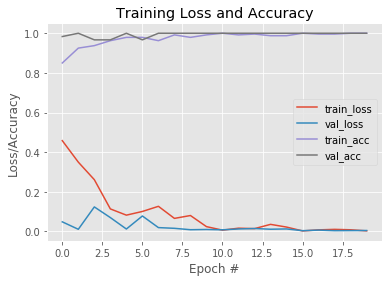

In [ ]:
#Conv nets
global input_shape,n_classes
train_data,train_labels,test_data,test_labels = load_and_split(1,ds_idx=0)
                                                              
train_data,test_data = standardize_data(train_data,test_data)

batch_size  = 10
epochs = 20
lr = .001

#model = sniffnet(input_shape,n_classes)
model = sniffresnet(input_shape,n_classes)
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=lr,momentum=.9),
             metrics=['accuracy'])

train_labels  = keras.utils.to_categorical(train_labels,n_classes)
test_labels = keras.utils.to_categorical(test_labels, n_classes)

print("[INFO] Training Network")
H = model.fit(train_data,train_labels,batch_size=batch_size,
         epochs=epochs,verbose=1,validation_data=(test_data,test_labels))

evaluate_model(test_data,test_labels,batch_size,model,H)


#### Funsion SniffNet

In [ ]:
#Fusion SniffNet
global n_classes, input_shape
train_data, train_labels, test_data, test_labels = load_and_split(1,
                                                                  read_wine_datasets=True)
                                                                 

# normalizing data
train_data, test_data = standardize_data(train_data, test_data)

train_data = split_datasamples_by_sensors(train_data)
test_data = split_datasamples_by_sensors(test_data)

batch_size = 10
epochs = 20
lr = .001

train_labels = keras.utils.to_categorical(train_labels, n_classes)
test_labels = keras.utils.to_categorical(test_labels, n_classes)
# defining model
model = sniffmultinose(input_shape, n_classes)

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=lr, momentum=.9),
              metrics=['accuracy'])


H = model.fit(train_data, train_labels, batch_size=batch_size,
              epochs=epochs, verbose=1, validation_data=(test_data, test_labels))

evaluate_model(test_data, test_labels, batch_size, model, H)

#### Create and print model configurations

In [ ]:
global n_classes, input_shape
train_data, train_labels, test_data, test_labels = load_and_split(2,ds_idx=0)

print("\t\tSniffConvNet sumarry\n\n")
sniffnet(input_shape,n_classes).sumary()

print("\t\tSniffResNet sumarry\n\n")
sniffresnet(input_shape,n_classes).sumary()

print("\t\tSniffMultinose sumarry\n\n")
sniffmultinose(input_shape, n_classes).sumary()




# Windowed Experiment

In [ ]:
def write_csv(path,file_name,data,mode="w+"):

    if ".csv" not in file_name:
        file_name += ".csv"
    with open(path+file_name,mode) as f:
        csv_writer = csv.writer(f, delimiter=',')
        csv_writer.writerows(data)
        f.close()


In [ ]:
def resettv(samp=1):
    """
    Setting the parameters for running the windowed experiment
    :param samp: The samp value
    :return: the parameters
    """
    parameters = {"fonollosa": {"ini_value": int(5000/5),
                                "start_value": int(6400/5),
                                "step": int(1400/5),
                                "end_value": int(19000/5)+1,
                                },
                  "windtunnel": {"ini_value": int(20*samp),
                                  "start_value": int(44*samp),
                                  "step": int(23*samp),
                                  "end_value": int(260*samp)},
                  "turbulent_gas_mixtures": {"ini_value": int(600/samp),
                                             "start_value": int(837/samp),
                                             "step": int(236/samp),
                                             "end_value": int(2970/samp)},
                  "QWines-CsystemTR": {"ini_value": int(160/samp),
                                       "start_value": int(474/samp),
                                       "step": int(314/samp),
                                       "end_value": int(3300/samp) + 1},
                  "QWinesEa-CsystemTR": {"ini_value": int(160/samp),
                                         "start_value": int(474/samp),
                                         "step": int(314/samp),
                                         "end_value": int(3300/samp) + 1}
                  # Uncomment the following lines if you have been authorized to 
                  #,"coffee_dataset": {"ini_value": int(29/samp),
                  #                   "start_value": int(56/samp),
                  #                   "step": int(26/samp),
                  #                   "end_value": int(299/samp)}
                  }
    return parameters


def load_dataset(ds_choice, ds_idx, read_wine_datasets=False):
    """
    Loads the dataset from the experiment
    :param ds_choice: Name of the dataset_chosen
    :param ds_idx: index indicating wich subset should be loaded
    :param read_wine_datasets:  True, if it is desired to read the wine dataset
    :return: data_samples,
            data labels,
            name of the dataset and name of the data subset,
            name of the input_shape
    """
    data = None
    labels = None
    dataset_name = None
    sub_dataset_name = None
    if not read_wine_datasets:
        data, labels, n_classes, dataset_name, sub_dataset_name = load(ds_choice, ds_idx)
    else:
        data, labels, n_classes, dataset_name, sub_dataset_name = load_wine(ds_choice)

    data = np.array(data)

    input_shape = data[0].shape

    return data, labels, n_classes, dataset_name, sub_dataset_name, input_shape


def run_windowed_experiment():
    parameters = resettv()
    list_of_keys = list(parameters.keys())

    # Creating indexes for each dataset being loaded
  
    datasets_names = {'fonollosa': [0, 1, 2, 3, 4],#  
                      'turbulent_gas_mixtures': [0],
                      'windtunnel': [0, 1, 2, 3, 4, 5]
                      # Un comment the following line 
                      # if you have been authorized to use the cofee dataset
                      #,'coffee_dataset': [0]
                      }

    batch_size = 10
    epochs = 20
    lr = .001

    names_list = list(datasets_names.keys())
    # Taking the parameters for fonollosa dataset as a test case
    # Iterating over model type, where the all the model types created are the normal ConvNet, Resnet an FusionNEt
    # Where for the fusion net the data needs a special treatment
    # models_names = ["SniffConvNet", "SniffResnet", "SniffMultinose"]
    models_names = [(0, "SniffConvNet"), (1, "SniffResnet"), (2, "SniffMultinose")]
    
    
    for (model_type, m_name) in models_names:
        print("\n\tUsin " + m_name + " architechture\n")
        model_folder = m_name + "/"
        # Interating over dataset names
        for i, name in enumerate(names_list):
            print("\n\tDataset " + name + "\n")
            sub_set_index = datasets_names[name]
            # Iterating over subset indexes
            for ss_idx in sub_set_index:
                print("\n\n ds_name:"+name+"\n\n")
                print("\n\n ds_idx:"+str(ss_idx)+"\n\n")
                f_params = parameters[name]
                data, labels, n_classes, dataset_name, sub_dataset_name, input_shape = load_dataset(name, ss_idx,
                                                                                                    read_wine_datasets=False)
                time_estimate_list = []
                toc = time.time()
                n_windows_processed = 0
                data, labels = sklearn.utils.shuffle(data, labels)
                for final_measurement in range(f_params['start_value'], f_params['end_value'], f_params['step']):
                    print("\n\n\t Window", final_measurement)
                    print("\n\n")
                    print("\n\tSubset " + sub_dataset_name + "\n")
                    train_data, test_data, train_labels, test_labels = train_test_split(
                        data[:, f_params['ini_value']:final_measurement, :],
                        labels, test_size=0.2)
                    # Normalizing data
                    train_data, test_data = standardize_data(train_data, test_data, test_data.shape[1:])

                    train_labels = keras.utils.to_categorical(train_labels, n_classes)
                    test_labels = keras.utils.to_categorical(test_labels, n_classes)

                    if model_type == 2:
                        # Reshapes data if usign the SniffMultinose
                        train_data = data_set_reshaped(train_data)
                        test_data = data_set_reshaped(test_data)
                        input_shape = train_data[0].shape
                        train_data = split_datasamples_by_sensors(train_data)
                        test_data = split_datasamples_by_sensors(test_data)

                    # defining model
                    model = None
                    if model_type == 0:
                        model = sniffnet(train_data.shape[1:], n_classes)
                    elif model_type == 1:
                        model = sniffresnet(train_data.shape[1:], n_classes)
                    elif model_type == 2:
                        model = sniffmultinose(input_shape, n_classes)
                    elif model_type == 3:
                        model = get_svm()
                    print("Model " + m_name + " has been created")

                    model.compile(loss="categorical_crossentropy",
                                  optimizer=keras.optimizers.SGD(lr=lr, momentum=.9),
                                  metrics=['accuracy'])
                    H = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, verbose=1,
                                  validation_data=(test_data, test_labels))

                    n_windows_processed += 1
                    
                    evaluate_model(test_data, test_labels, batch_size, model, epochs, H, n_classes,
                                   dataset_name, sub_dataset_name, model_folder,
                                   window_size=str(final_measurement), save_results=True)
                    
                tic = time.time()
                time_estimate_set_names = name+" "+sub_dataset_name
                total_estimate = tic - toc
                time_estimate_list.append([m_name,time_estimate_set_names,
                                           total_estimate, 
                                           n_windows_processed])
                #write_csv("drive/My Drive/","time_estimates_wt_fon_tgm_coff.csv",
                          #time_estimate_list,
                          #mode='a+')



def run_windowed_experiment_for_wine_dataset():
    print("\n\n\tExecuting experinment of wines dataset\n\n")
    parameters = resettv()
    list_of_keys = list(parameters.keys())

    # Creating indexes for each dataset being loaded
    names_list = ["QWines-CsystemTR", "QWinesEa-CsystemTR"]

    batch_size = 10
    epochs = 20
    lr = .001

    # Taking the parameters for fonollosa dataset as a test case
    # Iterating over model type, where the all the model types created are the normal ConvNet, Resnet an FusionNEt
    # Where for the fusion net the data needs a special treatment
    models_names = [(0, "SniffConvNet"), (1, "SniffResnet"), (2, "SniffMultinose")]#
    
    for (model_type, m_name) in models_names:
        print("\n\tUsin " + m_name + " architechture\n")
        model_folder = m_name + "/"

        # Interating over dataset names
        for i, name in enumerate(names_list):
            print("\n\tDataset " + name + "\n")
            # Iterating over subset indexes
            f_params = parameters[name]
            data, labels, n_classes, dataset_name, sub_dataset_name, input_shape = load_dataset(name, 0,
                                                                                                read_wine_datasets=True)
            
            time_estimate_list = []
            toc = time.time()
            n_windows_processed = 0
            data, labels = sklearn.utils.shuffle(data, labels)            
            for final_measurement in range(f_params['start_value'], f_params['end_value'], f_params['step']):
                print("\n\n\t Window", final_measurement)
                print("\n\n")
                train_data, test_data, train_labels, test_labels = train_test_split(
                    data[:, f_params['ini_value']:final_measurement, :],
                    labels, test_size=0.2)
                # Normalizing data
                train_data, test_data = standardize_data(train_data, test_data, test_data.shape[1:])
                # Reshaping data
                # train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2], 1)
                # test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2], 1)

                train_labels = keras.utils.to_categorical(train_labels, n_classes)
                test_labels = keras.utils.to_categorical(test_labels, n_classes)

                # defining model
                if model_type == 2:
                    # Reshapes data if usign the SniffMultinose
                    train_data = data_set_reshaped(train_data)
                    test_data = data_set_reshaped(test_data)
                    input_shape = train_data[0].shape
                    train_data = split_datasamples_by_sensors(train_data)
                    test_data = split_datasamples_by_sensors(test_data)

                # defining model
                model = None
                if model_type == 0:
                    model = sniffnet(train_data.shape[1:], n_classes)
                elif model_type == 1:
                    model = sniffresnet(train_data.shape[1:], n_classes)
                elif model_type == 2:
                    model = sniffmultinose(input_shape, n_classes)
                print("Model " + m_name + " has been created")

                model.compile(loss="categorical_crossentropy",
                              optimizer=keras.optimizers.SGD(lr=lr, momentum=.9),
                              metrics=['accuracy'])

                H = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, verbose=1,
                              validation_data=(test_data, test_labels))
                n_windows_processed += 1
                evaluate_model(test_data, test_labels, batch_size, model, epochs, H, n_classes,
                               dataset_name, sub_dataset_name, model_folder,
                               window_size=str(final_measurement), save_results=True)
            tic = time.time()
            time_estimate_set_names = name+" "+sub_dataset_name
            total_estimate = tic - toc
            time_estimate_list.append([m_name,time_estimate_set_names,
                                        total_estimate, 
                                        n_windows_processed])          
            write_csv("drive/My Drive/","time_estimates_wine.csv",time_estimate_list,
                      mode='a+')

In [ ]:
# creating csv header
time_estimate_list_titles = [["model type",
                              "datset and sub dataset name",
                              "total_execution_time",
                              "windows_processed"]]
time_estimate_list_titles

[['model type',
  'datset and sub dataset name',
  'total_execution_time',
  'windows_processed']]

In [ ]:
write_csv("drive/My Drive/","time_estimates_wt_fon_tgm.csv",time_estimate_list_titles)

In [ ]:
run_windowed_experiment()

In [ ]:
write_csv("drive/My Drive/","time_estimates_wine.csv",time_estimate_list_titles)

In [ ]:
run_windowed_experiment_for_wine_dataset()